# Plot trends in OLR, ASR, and AIRS spectral OLR by month

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load CERES-EBAF data

In [2]:
ceres_dir = '/glade/work/jonahshaw/obs/CERES'
ceres_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc'

In [3]:
ceres_ds = xr.open_dataset('%s/%s' % (ceres_dir,ceres_file))

#### Add an absorbed solar radiation variable

In [4]:
ceres_ds['ASR'] = ceres_ds['solar_mon'] - ceres_ds['toa_sw_all_mon']

#### Add an albedo variable

In [5]:
temp_alb = (ceres_ds['toa_sw_all_mon'] / ceres_ds['solar_mon'])
# weird 2-step process required??
ceres_ds['albedo'] = temp_alb.where(ceres_ds['solar_mon'] > 15) #.where(temp_alb > 15,np.nan) # poorly defined when insolation is less than 15 W/m^2

### Plot month OLRs for the Arctic Ocean (70-90N)

If I want to use a better mask, should I use the LANDFRAC variable in CESM or is there something better?

In [6]:
olr_wgt = add_weights(ceres_ds['toa_lw_all_mon'])

In [7]:
month_groups = olr_wgt.groupby('time.month')

Compute monthly OLRs (inefficient, could vectorize)

In [8]:
olr_temp = []
labels = []

for label,month in month_groups:
    arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat<70)
    
    olr_temp.append(arc_ocn_avg)
    labels.append(label)
#     break
olr_temp = np.array(olr_temp)

#### Sanity plot looks good

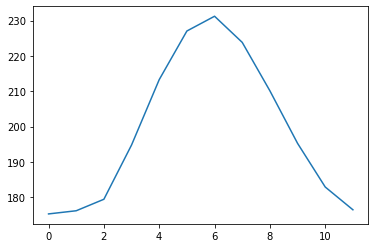

In [9]:
plt.plot(olr_temp)

### Plot a monthly trend

In [10]:
# average over the Arctic Ocean spatially, but not temporally
spat_avg = masked_average(olr_wgt,weights=olr_wgt['cell_weight'],mask=olr_wgt.lat<70,dim=['lat','lon'])

#### All months sanity plot looks good

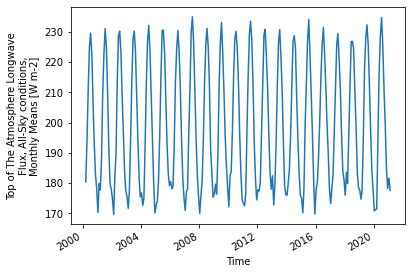

In [11]:
spat_avg.plot()

Text(0.5, 0.98, 'CERES OLR (70-90N)')

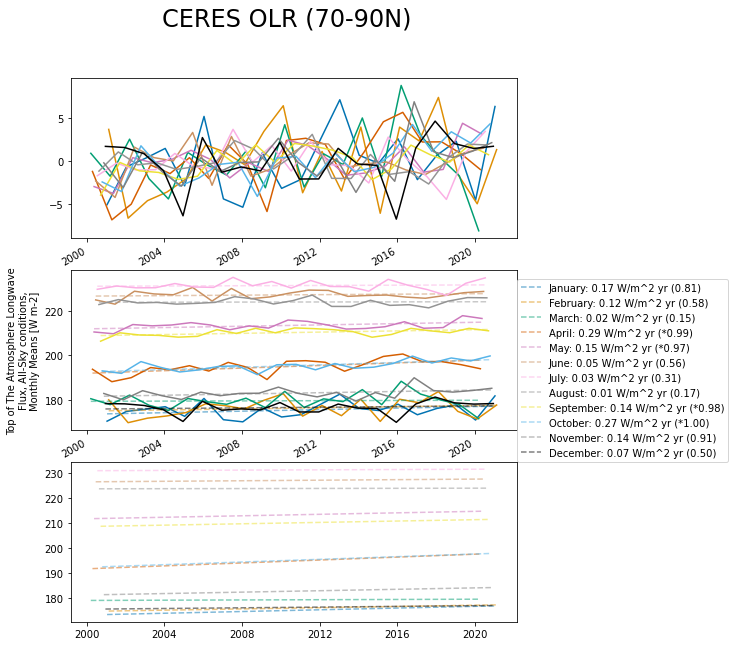

In [14]:
# For making month labels
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

fig,axes = plt.subplots(3,1,figsize=(8,10))

lines=[]
mon_groups = spat_avg.groupby('time.month')

for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):
    mon_norm = mon - mon.mean() # normalize to the average

    out = regress_1d(mon['time.year'],mon)
    _slope, _intercept, _r_value, _p_value, _std_err =stats.linregress(mon['time.year'],mon)
    
    N=len(mon) # data point count (could be len(mon['time.year']) <-- same)
    std_x=np.std(mon['time.year']) # this works because each measurement is from a different year.
    std_y=np.std(mon)
    slope_calculated=_r_value*(std_y/std_x) # this is just getting the slope via the r-value and the stds
    
    ## ASSESS SIGNIFICANCE OF REGRESSION
#     print('Null Hypothesis: The true correlation is zero. ')
    dof=N-2
    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_r_value*np.sqrt(N-2)/np.sqrt((1-_r_value*_r_value))

#     if t>tcrit:
#         print('Since t=',np.round(t,2),'exceeds tcrit=',np.round(tcrit,2),' we can reject the null hypothesis')
#     if t<tcrit:
#         print('Since t=',np.round(t,2),'does not exceed tcrit=',np.round(tcrit,2),' we cannot reject the null hypothesis')
        
    statsig_percent=(1-_p_value)*100
#     print('stats.linregress statistical significance (%)',np.round(statsig_percent,0))
        
#     print(np.round(_slope,3))
#     print(np.round(slope_calculated.values,3))
    
    # These regressions have the same output, good check
#     print('regress coef: %.3f, regress intercept: %.3f' % (out.coef_,out.intercept_))
#     print('stats coef: %.3f, stats intercept: %.3f' % (_slope,_intercept))
    
    line = (mon['time.year'].values*_slope + _intercept).squeeze()
    if t>tcrit:
        label = '%s: %.2f W/m^2 yr (*%.2f)' % (mon_dict[str(ind)],_slope, (1-_p_value))
    else:
        label = '%s: %.2f W/m^2 yr (%.2f)' % (mon_dict[str(ind)],_slope, (1-_p_value))
    
    
    mon_norm.plot(label=label,ax=axes[0],color=color)
    out = mon.plot(label=label,ax=axes[1],color=color)
    
    axes[1].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)
    axes[2].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)    
    
    lines.append(out)
    
axes[2].legend(loc=[1,1])

fig.suptitle('CERES OLR (70-90N)',fontsize=24)

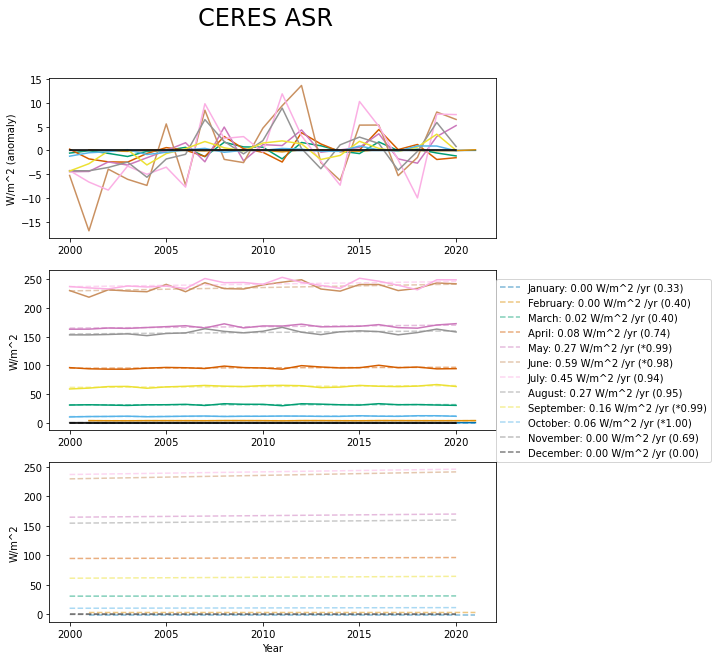

In [15]:
plot_trends(ceres_ds['ASR'],'CERES ASR')

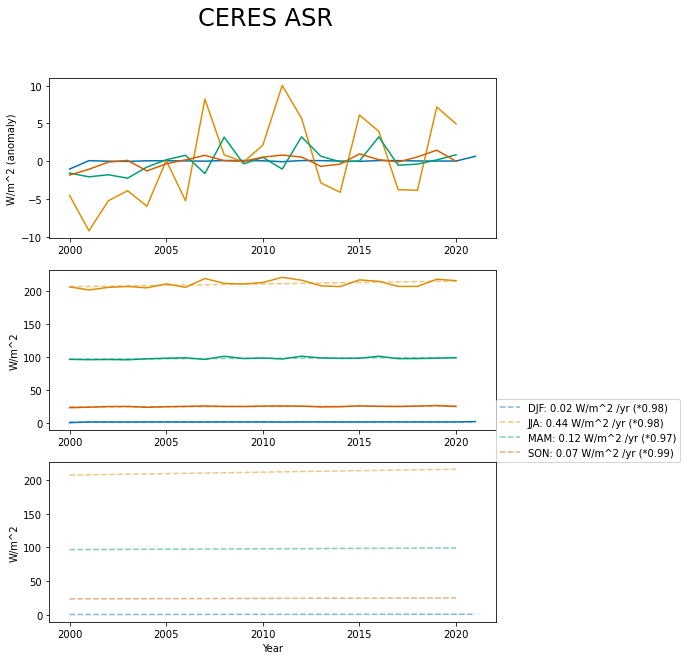

In [16]:
out = plot_trends(ceres_ds['ASR'],'CERES ASR',seasonal=True)

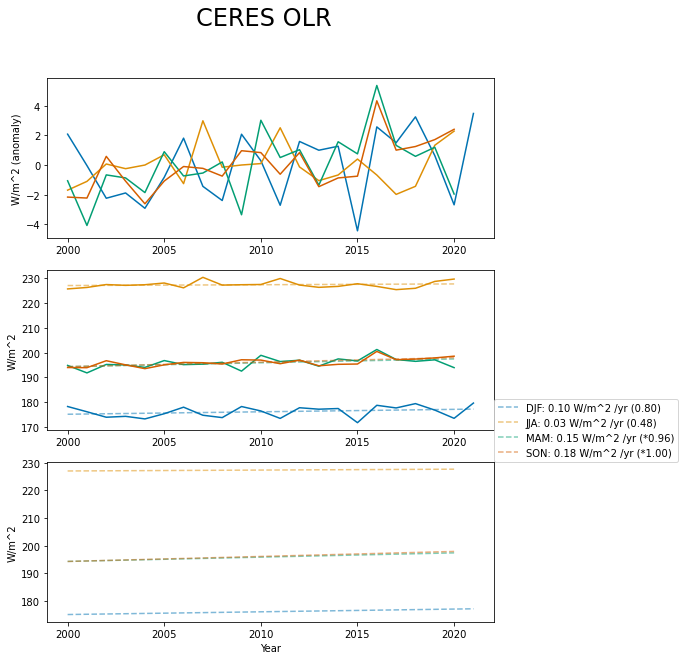

In [17]:
out = plot_trends(ceres_ds['toa_lw_all_mon'],'CERES OLR',seasonal=True)

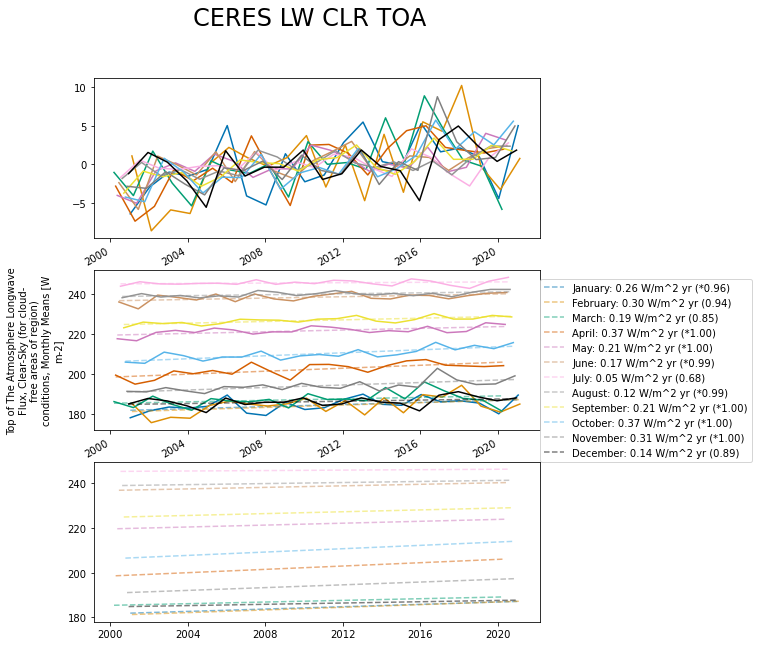

In [63]:
plot_trends(ceres_ds['toa_lw_clr_c_mon'],'CERES LW CLR TOA')

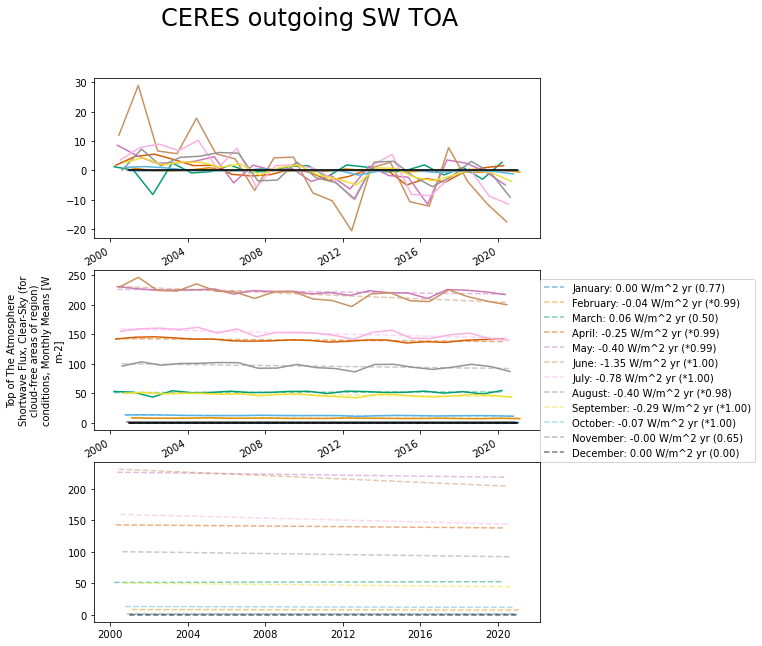

In [64]:
plot_trends(ceres_ds['toa_sw_clr_c_mon'],'CERES outgoing SW TOA')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


nan in monthly averages for DJF


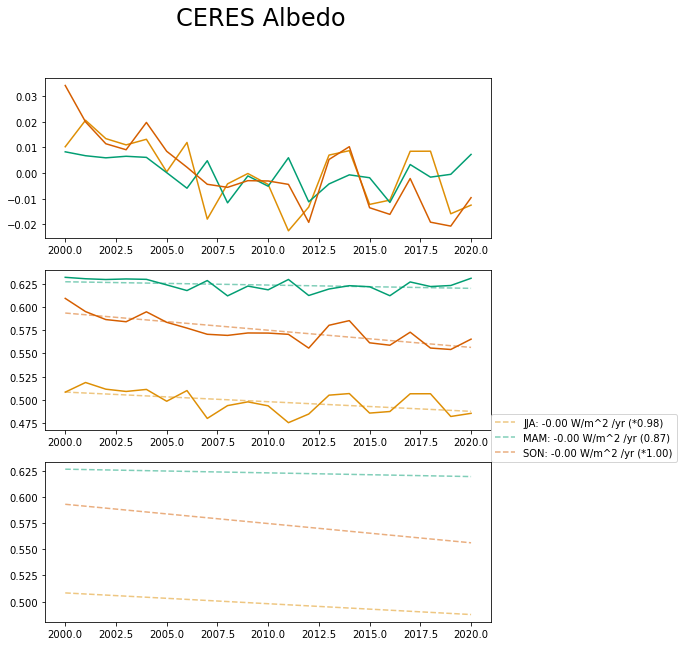

In [81]:
error = plot_trends(ceres_ds['albedo'],'CERES Albedo',seasonal=True)

## Plot trends in surface temperature from the NASA GISS dataset

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [61]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [62]:
ls $gisstemp_path

air.2x2.1200.mon.anom.comb.nc        GISTEMP_timeseries.nc
air.2x2.1200.mon.anom.comb.nc.v2019  readme.txt


In [63]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here
# giss2 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc.v2019'))

In [64]:
giss_tsel = giss1.sel(time=slice('2000-03','2021-03'))

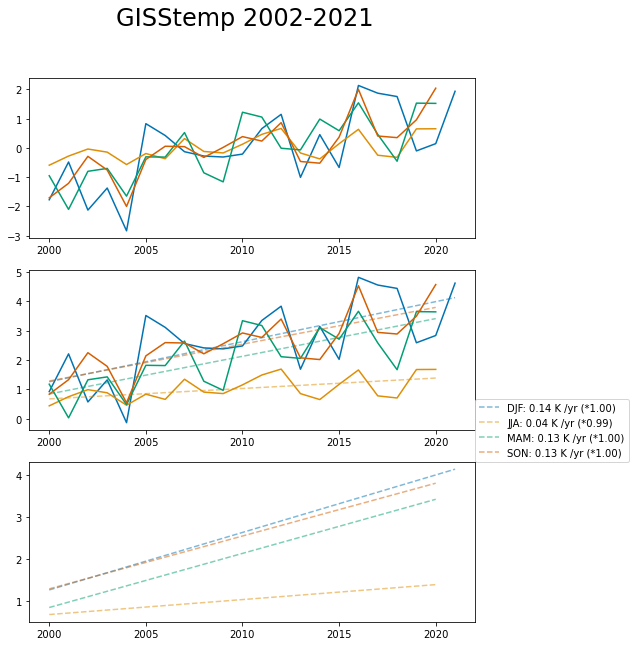

In [87]:
plot_trends(giss_tsel['air'],'GISStemp 2002-2021',units='K',seasonal=True)

### The GISS data shows the monthly anomaly, so there are no absolute temperature values

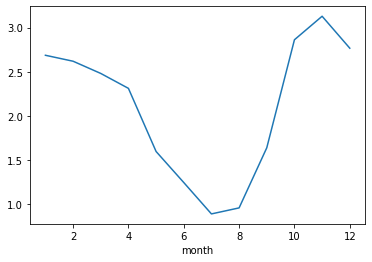

In [88]:
giss_T = add_weights(giss_tsel['air'])

spat_avg = masked_average(giss_T,weights=giss_T['cell_weight'],mask=giss_T.lat<70,dim=['lat','lon'])

spat_avg.groupby('time.month').mean('time').plot()

## GOCCP liquid cloud amount

In [21]:
goccp_dir = '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/'

In [22]:
# identifying strings
phase_str = 'Phase330m'
height_str = 'High330m'

In [23]:
height_files = glob.glob('%s/*/*%s*.nc' % (goccp_dir,height_str))
height_files.sort()

phase_files = glob.glob('%s/*/*%s*.nc' % (goccp_dir,phase_str))
phase_files.sort()

In [24]:
goccp_phase = xr.open_mfdataset(phase_files)

goccp_height = xr.open_mfdataset(height_files)

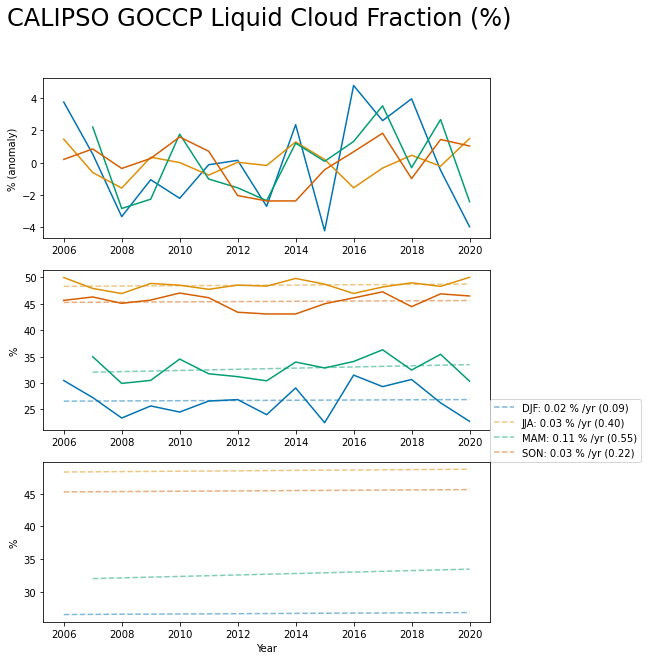

In [25]:
plot_trends(100*goccp_phase['cltcalipso_liq'],'CALIPSO GOCCP Liquid Cloud Fraction (%)',units='%',seasonal=True)

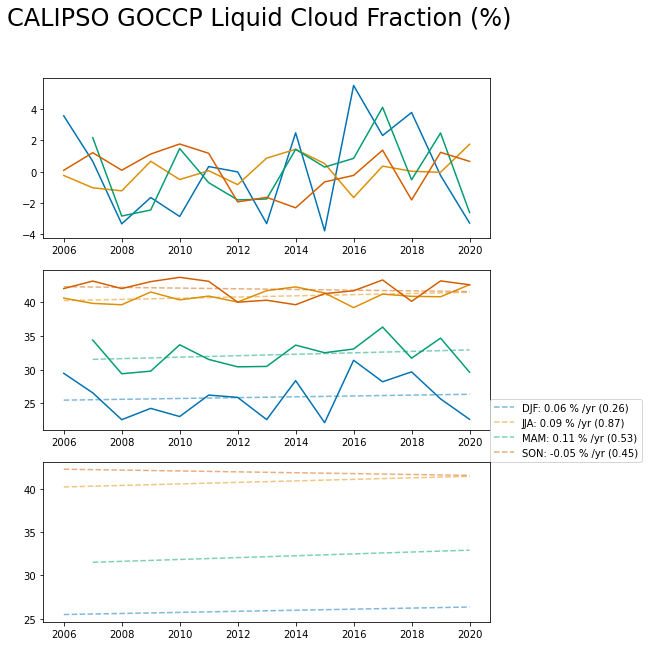

In [97]:
plot_trends(100*goccp_phase['cllcalipso_liq'],'CALIPSO GOCCP Liquid Cloud Fraction (%)',units='%',seasonal=True)

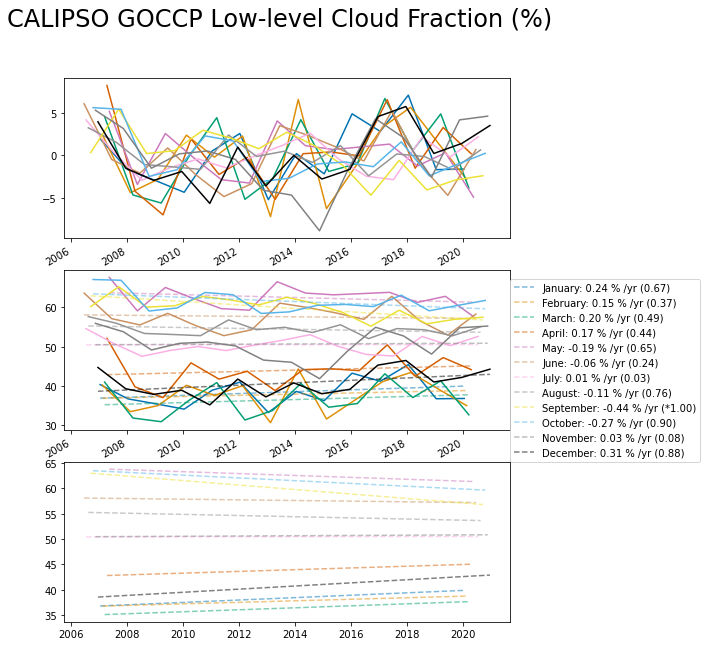

In [81]:
plot_trends(100*goccp_height['cllcalipso'],'CALIPSO GOCCP Low-level Cloud Fraction (%)',units='%')

### This is interesting! Why is there less low-level cloud in August, September, and October?

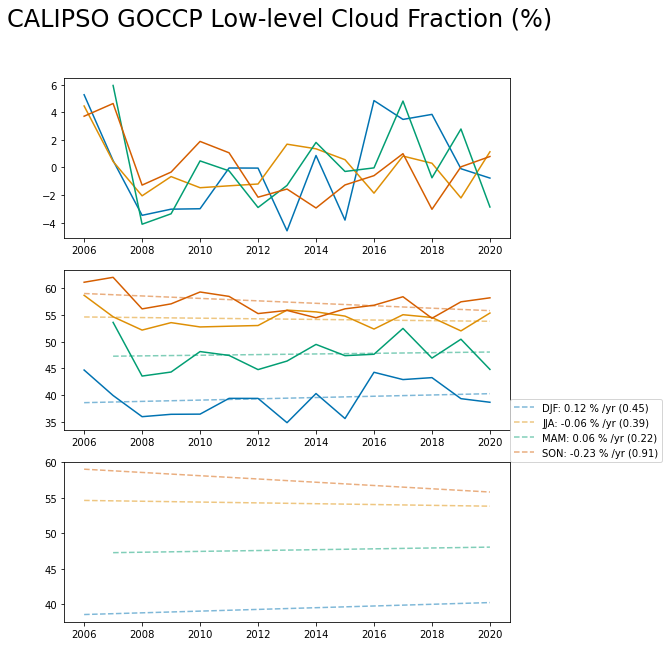

In [96]:
plot_trends(100*goccp_height['cllcalipso'],'CALIPSO GOCCP Low-level Cloud Fraction (%)',units='%',seasonal=True)

In [19]:
def is_aso(month): # August, September, October selection, returns an iterable of booleans
    return (month >= 8) & (month <= 10)


In [58]:
def plot_trends_simp(ds,time_var='time',units='W/m^2',title='Trends????',var_name=None):
    '''
    To call for processed data
    '''
    
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    
    # For making month labels
    mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
               '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
               }
    
    var_wgt = add_weights(ds)
    # average over the Arctic Ocean spatially, but not temporally
    try:
        spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.lat<70,dim=['lat','lon'])
    except:
        spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.latitude<70,dim=['latitude','longitude'])
            
    _slope, _intercept, _r_value, _p_value, _std_err =stats.linregress(spat_avg[time_var],spat_avg)

    N=len(spat_avg) # data point count (could be len(mon['time.year']) <-- same)

    dof=N-2
    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_r_value*np.sqrt(N-2)/np.sqrt((1-_r_value*_r_value))

    statsig_percent=(1-_p_value)*100

    line = (spat_avg[time_var].values*_slope + _intercept).squeeze()
#             print('tcrit:',tcrit,' t: ',t)
#     time_label = ind if seasonal else mon_dict[str(ind)]
    if np.abs(t)>tcrit:
        label = '%.2f %s /yr (*%.2f)' % (_slope, units, (1-_p_value))
    else:
        label = '%.2f %s /yr (%.2f)' % (_slope, units, (1-_p_value))

    ax.plot(spat_avg[time_var],spat_avg,label=None,color=color)
    ax.plot(spat_avg[time_var],line,alpha=0.5,linestyle='dashed',label=label,color=color) # was plotting by 'time' instead of 'time.year' originally

    ax.set_ylabel('%s (%s)' % (var_name,units))
    ax.set_xlabel('Year')
    ax.legend() # loc=[1,1]

    fig.suptitle(title,fontsize=24)

In [27]:
seasonal_data = goccp_height['cllcalipso'].sel(time=is_aso(goccp_height['time.month']))

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


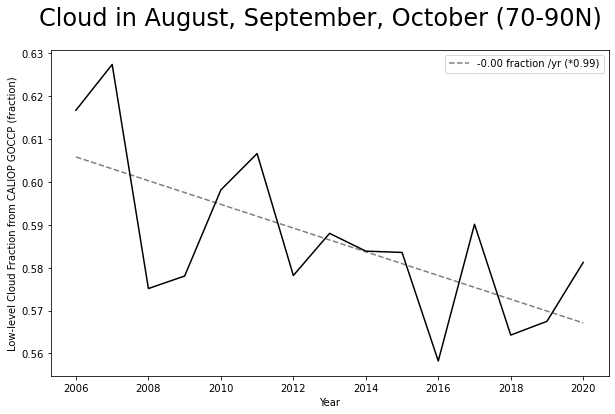

In [68]:
plot_trends_simp(seasonal_data.groupby('time.year').mean('time'),time_var='year',title='Cloud in August, September, October (70-90N)',var_name='Low-level Cloud Fraction from CALIOP GOCCP',units='fraction')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


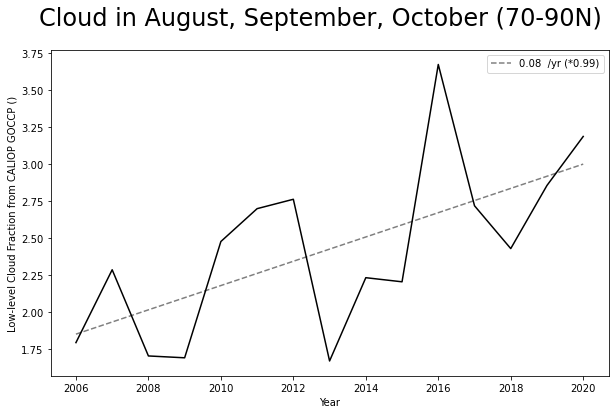

In [67]:
giss_caliop = giss1.sel(time=slice('2006-06','2020-12'))

plot_trends_simp(giss_caliop['air'].groupby('time.year').mean('time'),time_var='year',title='Cloud in August, September, October (70-90N)',var_name='Low-level Cloud Fraction from CALIOP GOCCP',units='')

In [ ]:
giss_tsel['air']

In [57]:
seasonal_data.groupby('time.year').mean('time')

<xarray.DataArray 'cllcalipso' (year: 15, latitude: 90, longitude: 180)>
dask.array<stack, shape=(15, 90, 180), dtype=float32, chunksize=(1, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * year       (year) int64 2006 2007 2008 2009 2010 ... 2017 2018 2019 2020

In [105]:
out = goccp_height['cltcalipso'].where(goccp_height['time.month']==slice(7,9))

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


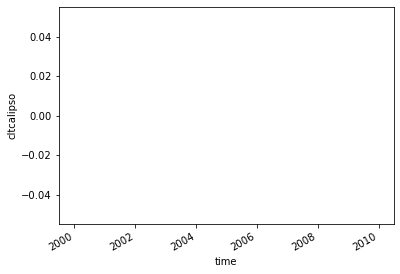

In [108]:
out.mean(dim=['latitude','longitude']).plot()

In [57]:
arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat>70)

In [58]:
arc_ocn_avg

<xarray.DataArray ()>
array(239.40678, dtype=float32)
Attributes:
    long_name:      Top of The Atmosphere Longwave Flux, All-Sky conditions, ...
    standard_name:  TOA Longwave Flux - All-Sky
    CF_name:        toa_outgoing_longwave_flux
    comment:        none
    units:          W m-2
    valid_min:            0.00000
    valid_max:            400.000

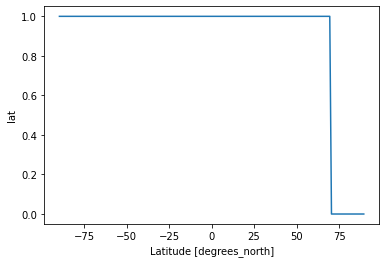

In [55]:
(month.lat<70).plot()

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


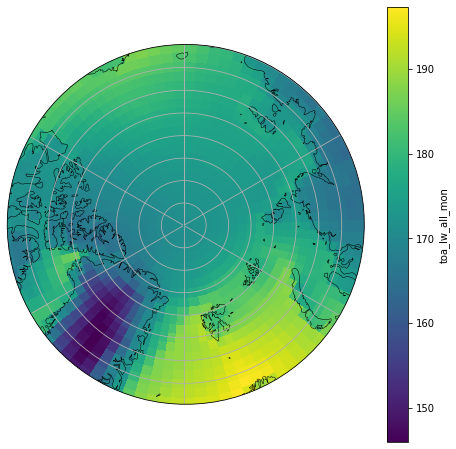

In [43]:
fig,ax = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[8,8])

polarCentral_set_latlim([70,90], ax)

month.where(month.lat>70).mean('time').plot(ax=ax, transform=ccrs.PlateCarree())

add_map_features(ax)

In [21]:
type(group)

xarray.core.dataarray.DataArray

In [33]:
ax.plot(month.where(month.lat>70).mean('time'),projection=ccrs.NorthPolarStereo())

AttributeError: 'Line2D' object has no property 'projection'

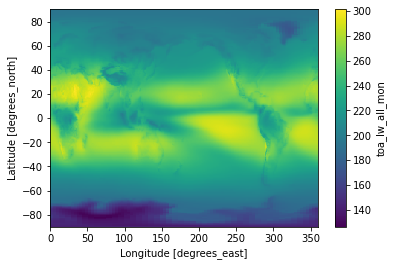

In [9]:
ceres_ds['toa_lw_all_mon'].mean('time').plot()

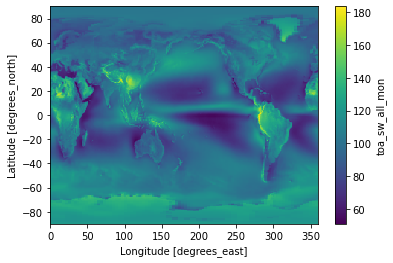

In [10]:
ceres_ds['toa_sw_all_mon'].mean('time').plot()

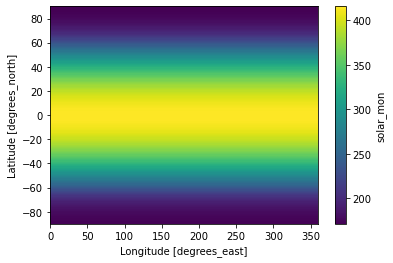

In [11]:
ceres_ds['solar_mon'].mean('time').plot()

In [ ]:
OSR=ds.toa_sw_all_mon.mean('time') ### outgoing solar radiation, measured by CERES
SOLIN=ds.solar_mon.mean('time')    ### incoming solar radiation, from the sun
ASR=SOLIN-OSR  ### sign convention, positive down.  incoming solar radiation minus outgoing solar radiation